In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

2025-07-15 04:20:19.098977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752553219.381322      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752553219.462559      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Constants
BASE_DIR = "/kaggle/input/melanoma-cancer-dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
# Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [9]:
# Improved CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-15 04:22:15.662981: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,425 (497.75 KB)

 Trainable params: 126,977 (496.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint("best_skin_cancer_model.h5", monitor='val_loss', save_best_only=True, verbose=1)




In [15]:
# Train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    class_weight=class_weights
)



Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8208 - auc: 0.9050 - loss: 0.3897
Epoch 1: val_loss improved from 0.60413 to 0.38627, saving model to best_skin_cancer_model.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1327s 4s/step - accuracy: 0.8208 - auc: 0.9050 - loss: 0.3897 - val_accuracy: 0.8231 - val_auc: 0.9056 - val_loss: 0.3863 - learning_rate: 3.0000e-04
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 19:02 3s/step - accuracy: 0.8125 - auc: 0.8902 - loss: 0.4028

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.38627
371/371 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8125 - auc: 0.8902 - loss: 0.4028 - val_accuracy: 0.8266 - val_auc: 0.9103 - val_loss: 0.3866 - learning_rate: 3.0000e-04
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8348 - auc: 0.9145 - loss: 0.3710
Epoch 3: val_loss did not improve from 0.38627
371/371 ━━━━━━━━━━━━━━━━━━━━ 1279s 3s/step - accuracy: 0.8348 - auc: 0.9145 - loss: 0.3710 - val_accuracy: 0.7213 - val_auc: 0.8903 - val_loss: 0.5761 - learning_rate: 3.0000e-04
Epoch 4/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 19:04 3s/step - accuracy: 0.8438 - auc: 0.8785 - loss: 0.3895
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 4: val_loss did not improve from 0.38627
371/371 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.8438 - auc: 0.8785 - loss: 0.3895 - val_accuracy: 0.7293 - val_auc: 0.8906 - val_loss: 0.5550 - learning_rate: 3.0000e-04
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0

In [16]:
# Evaluation
preds = model.predict(test_generator, verbose=1)
pred_labels = (preds > 0.5).astype("int32").flatten()
true_labels = test_generator.classes

# Metrics
f1 = f1_score(true_labels, pred_labels)
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))




63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step
F1 Score: 0.8691
Classification Report:
               precision    recall  f1-score   support

      Benign       0.87      0.87      0.87      1000
   Malignant       0.87      0.87      0.87      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



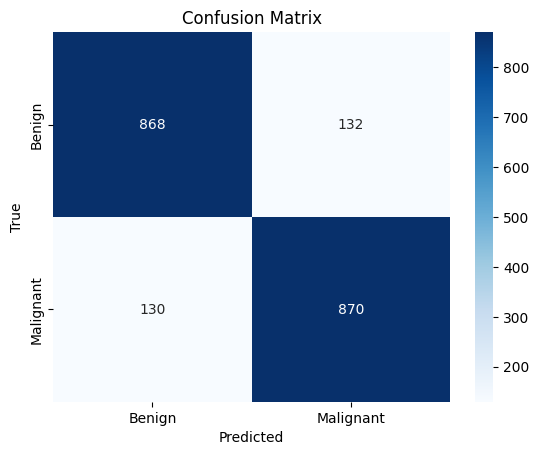

In [17]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


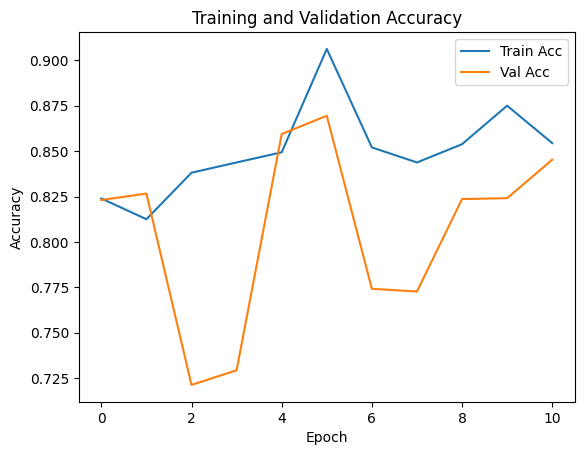

In [18]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [20]:
# Load model for prediction
model = load_model("best_skin_cancer_model.h5")

def predict_skin_cancer(image_path, model):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    class_label = "Malignant" if prediction > 0.5 else "Benign"

    plt.imshow(img)
    plt.title(f"Predicted: {class_label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


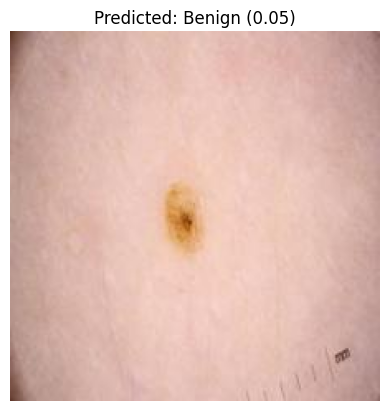

In [21]:
# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Benign/6313.jpg", model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


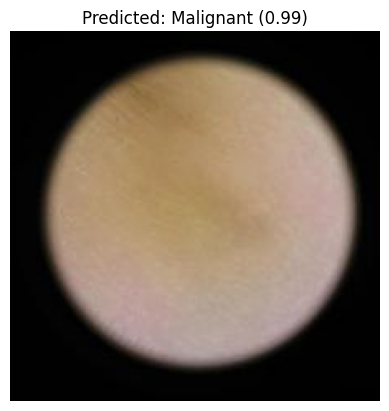

In [25]:
# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5611.jpg", model)